# Model training

In [50]:
from sklearn import tree
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR

from tabulate import tabulate
import pandas as pd
import math

In [60]:
#debugging stuff
def evaluate_stress_predictions(predicted_values,true_values):
    # Initialize counters
    correct_predictions = 0
    overestimated = 0
    underestimated = 0

    # Compare true and predicted values
    for true, pred in zip(true_values, predicted_values):
        if true == pred:
            correct_predictions += 1
        elif true == 'low' and pred == 'medium':
            underestimated += 1
        elif true == 'medium' and pred == 'low':
            overestimated += 1
        elif true == 'medium' and pred == 'high':
            underestimated += 1
        elif true == 'high' and pred == 'medium':
            overestimated += 1
        elif true == 'high' and pred == 'low':
            overestimated += 1
        elif true == 'low' and pred == 'high':
            underestimated += 1

    # Return counts
    return correct_predictions, overestimated, underestimated
    

def evaluate_age_predictions(predicted_values, true_values, error):
    # Initialize counters
    correct_predictions = 0
    overestimated = 0
    underestimated = 0
    
    # Compare true and predicted values
    for true, pred in zip(true_values, predicted_values):
        true = round(true)
        pred = round(pred)
        if abs(pred - true) <= error:  # Check if the absolute difference is within the error
            correct_predictions += 1
        elif pred > true:
            overestimated += 1
        else:
            underestimated += 1
    
    return correct_predictions, overestimated, underestimated


def load_dataset():
    train_data = pd.read_csv('./dataset/train_dataset.csv')
    test_data = pd.read_csv('./dataset/test_dataset.csv')
    # Preprocess training and testing dataset
    train_data['bedtime'] = pd.to_datetime(train_data['bedtime']).dt.hour
    train_data['activity_intensity'] = train_data['activity_intensity'].map({'low': 0, 'moderate': 1, 'high': 2})

    test_data['bedtime'] = pd.to_datetime(test_data['bedtime']).dt.hour
    test_data['activity_intensity'] = test_data['activity_intensity'].map({'low': 0, 'moderate': 1, 'high': 2})
    return train_data, test_data


train_data, test_data = load_dataset()

def get_vars(c="stress"):
    #train_data, test_data = load_dataset()
    
    if(c == "stress"):
        train_features = train_data[['bedtime', 'activity_intensity', 'byear']]
        test_features = test_data[['bedtime', 'activity_intensity', 'byear']]
        
        train_target = train_data['stress_level']
        test_target = test_data['stress_level']
      
        
    else:
        train_features = train_data[['stress', 'activity_intensity', 'byear']]
        test_features = test_data[['stress', 'activity_intensity', 'byear']]
        
        train_target = train_data['mental_age']
        test_target = test_data['mental_age']
        
        
    return train_features, train_target, test_features, test_target

def print_stats(pred,test,banner,c="stress"):
    '''
    try:
        head=['Accuracy',accuracy_score(pred,test)]
    except:
        mse = round(mean_squared_error(test, pred),2)
        head= ['Mean Squared Error', str(mse) + " ("+str(math.sqrt(mse))+")"]
    '''
    if(c== "stress"):
        head=['Test accuracy',accuracy_score(pred,test)]
    else:
        mse = round(mean_squared_error(test, pred),2)
        head= ['Mean Squared Error', str(mse) + " ("+str(math.sqrt(mse))+")"]
    
    if(c=="stress"):
        correct, over, under = evaluate_stress_predictions(pred, test)
    else:
        #correct, over, under = evaluate_age_predictions(pred, test,max(1,int(math.sqrt(mse))))
        correct, over, under = evaluate_age_predictions(pred, test,int(math.sqrt(mse)))
        
    data = [head,
        ["Correct Predictions:", str(correct)+"/"+str(len(test))],
        ["Overestimated:",  str(over)+"/"+str(len(test))],
        ["Underestimated:",  str(under)+"/"+str(len(test))]]
    print("\n\n"+tabulate(data, headers=[banner, ""]))

# Decision tree

### Stress

In [82]:
train_features, train_target, test_features, test_target = get_vars()

clf = DecisionTreeClassifier(class_weight="balanced",random_state=42)
clf.fit(train_features, train_target) #Train the classifier
no_param_cv = cross_val_score(clf, train_features, train_target, cv=5)
pred_target = clf.predict(test_features) #Make predictions
print("5-fold cross validation mean accuracy",no_param_cv.mean())
print_stats(pred_target,test_target ,"Decision tree stress (no params)") #Evaluates


# Hyper parameters
param_grid = {"max_depth":[None,1,2,3,4,5,6], 'min_samples_leaf': [1,2,4,7], 'min_samples_split': [2,3,4]}

prog_tree_sh = GridSearchCV(clf, param_grid=param_grid, cv=5).fit(train_features, train_target)
pred_target = prog_tree_sh.best_estimator_.predict(test_features) #Make predictions

print("5-fold cross validation mean accuracy",prog_tree_sh.best_score_)
print_stats(pred_target,test_target ,"Decision tree stress (best_params)") #Evaluates
print(prog_tree_sh.best_params_)
#tree.plot_tree(prog_tree_sh.best_estimator_)

5-fold cross validation mean accuracy 0.33103448275862074


Decision tree stress (no params)
----------------------------------  -------------------
Test accuracy                       0.30612244897959184
Correct Predictions:                30/98
Overestimated:                      16/98
Underestimated:                     52/98
5-fold cross validation mean accuracy 0.35172413793103446


Decision tree stress (best_params)
------------------------------------  -------------------
Test accuracy                         0.35714285714285715
Correct Predictions:                  35/98
Overestimated:                        41/98
Underestimated:                       22/98
{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


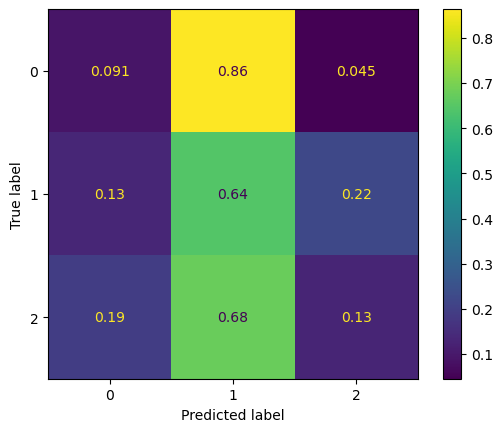

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(test_target, pred_target)
ConfusionMatrixDisplay(cm / cm.sum(axis=1)[:,None]).plot()

### Mental_age

In [84]:
train_features, train_target, test_features, test_target = get_vars(c="age")

clf = DecisionTreeRegressor(random_state=42)
clf.fit(train_features, train_target) #Train the classifier
no_param_cv = cross_val_score(clf, train_features, train_target, cv=5)
pred_target = clf.predict(test_features) #Make predictions

print_stats(test_target,pred_target,"Decision tree mental age (no_params)","age") #Evaluates

# Hyper parameters
param_grid = {"max_depth":[None,1,2,3,4,5,6], 'min_samples_leaf': [1,2,4,7], 'min_samples_split': [2,3,4]}

prog_tree_sh = GridSearchCV(clf, param_grid=param_grid, cv=5).fit(train_features, train_target)
pred_target = prog_tree_sh.best_estimator_.predict(test_features) #Make predictions

print_stats(pred_target,test_target ,"Decision tree mental age (best_params)","age") #Evaluates
print(prog_tree_sh.best_params_)



Decision tree mental age (no_params)
--------------------------------------  -------------------------
Mean Squared Error                      2.41 (1.5524174696260025)
Correct Predictions:                    76/98
Overestimated:                          11/98
Underestimated:                         11/98


Decision tree mental age (best_params)
----------------------------------------  -------------------------
Mean Squared Error                        2.41 (1.5524174696260025)
Correct Predictions:                      76/98
Overestimated:                            11/98
Underestimated:                           11/98
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [16]:
#clf.get_params()#hyperparam

# Random forest

### Stress

In [31]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [88]:
train_features, train_target, test_features, test_target = get_vars()

rf_clf = RandomForestClassifier(class_weight="balanced",random_state=42)
rf_clf.fit(train_features, train_target) #Train the classifier
no_param_cv = cross_val_score(rf_clf, train_features, train_target, cv=5)
pred_target = rf_clf.predict(test_features) #Make predictions
print("5-fold cross validation mean accuracy",no_param_cv.mean())
print_stats(test_target, pred_target,"Random forest stress (no params)") #Evaluates

# Hyper parameters
param_grid = {"max_depth":[None,1,2,3,4,5,6], 'min_samples_leaf': [1,2,4,7], 'min_samples_split': [2,3,4]}

prog_tree_sh = GridSearchCV(rf_clf, param_grid=param_grid, cv=5).fit(train_features, train_target)
pred_target = prog_tree_sh.best_estimator_.predict(test_features) #Make predictions

print("5-fold cross validation mean accuracy",prog_tree_sh.best_score_)
print_stats(pred_target,test_target ,"Random forest stress (best params)") #Evaluates
print(prog_tree_sh.best_params_)

5-fold cross validation mean accuracy 0.3517241379310345


Random forest stress (no params)
----------------------------------  -------------------
Test accuracy                       0.35714285714285715
Correct Predictions:                35/98
Overestimated:                      40/98
Underestimated:                     23/98
5-fold cross validation mean accuracy 0.3586206896551724


Random forest stress (best params)
------------------------------------  ------------------
Test accuracy                         0.2755102040816326
Correct Predictions:                  27/98
Overestimated:                        33/98
Underestimated:                       38/98
{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}


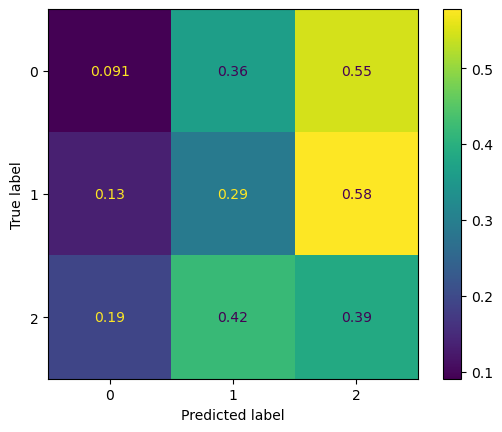

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(test_target, pred_target)
ConfusionMatrixDisplay(cm / cm.sum(axis=1)[:,None]).plot()

### Mental_age

In [87]:
train_features, train_target, test_features, test_target = get_vars(c="age")

rf_clf = RandomForestRegressor(random_state=42)
rf_clf.fit(train_features, train_target) #Train the classifier
no_param_cv = cross_val_score(rf_clf, train_features, train_target, cv=5)
pred_target = rf_clf.predict(test_features) #Make predictions

print_stats(test_target, pred_target,"Random forest age (no params)","age") #Evaluates

# Hyper parameters
param_grid = {"max_depth":[None,1,2,3,4,5,6], 'min_samples_leaf': [1,2,4,7], 'min_samples_split': [2,3,4]}

prog_tree_sh = GridSearchCV(rf_clf, param_grid=param_grid, cv=5).fit(train_features, train_target)
pred_target = prog_tree_sh.best_estimator_.predict(test_features) #Make predictions


print_stats(pred_target,test_target ,"Random forest mental age (best params)", "age") #Evaluates
print(prog_tree_sh.best_params_)



Random forest age (no params)
-------------------------------  -----------------------
Mean Squared Error               1.5 (1.224744871391589)
Correct Predictions:             88/98
Overestimated:                   7/98
Underestimated:                  3/98


Random forest mental age (best params)
----------------------------------------  -----------------------
Mean Squared Error                        1.5 (1.224744871391589)
Correct Predictions:                      88/98
Overestimated:                            3/98
Underestimated:                           7/98
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


# Support vector

### Stress

In [70]:
train_features, train_target, test_features, test_target = get_vars()


svm_clf = SVC(class_weight="balanced") 
svm_clf.fit(train_features, train_target) #Train the classifier
pred_target = svm_clf.predict(test_features)

print_stats(test_target, pred_target,"Support Vector stress") #Evaluates



param_grid = [{"kernel":["linear"], "C":[1,10]}, {"kernel":["rbf"], "C":[1,10], "gamma":[0.001, 0.0001]}]
svm_sh = GridSearchCV(svm_clf, param_grid, cv=5).fit(train_features, train_target) #Optimize hyperparameters and train the classifier
pred_target = svm_sh.best_estimator_.predict(test_features) #Make predictions

print_stats(pred_target,test_target ,"Support Vector stress") #Evaluates
print(svm_sh.best_params_)




Support Vector stress
-----------------------  -------------------
Test accuracy            0.45918367346938777
Correct Predictions:     45/98
Overestimated:           0/98
Underestimated:          53/98


Support Vector stress
-----------------------  ------------------
Test accuracy            0.2653061224489796
Correct Predictions:     26/98
Overestimated:           33/98
Underestimated:          39/98
{'C': 10, 'kernel': 'linear'}


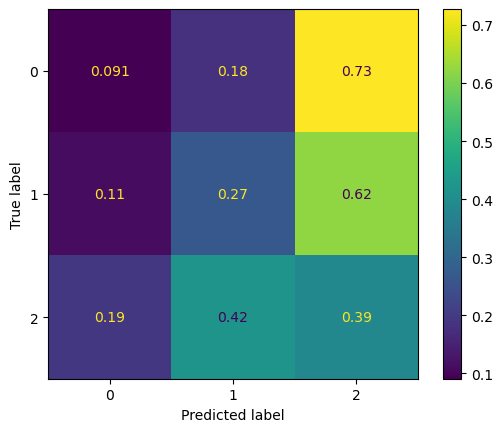

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(test_target, pred_target)
ConfusionMatrixDisplay(cm / cm.sum(axis=1)[:,None]).plot()

### Mental_age

In [22]:
train_features, train_target, test_features, test_target = get_vars(c="age")


svr_clf = SVR() 
svr_clf.fit(train_features, train_target) #Train the classifier
pred_target = svr_clf.predict(test_features)

print_stats(test_target, pred_target,"Support Vector mental age","age") #Evaluates



param_grid = [{"kernel":["linear"], "C":[1,10]}, {"kernel":["rbf"], "C":[1,10], "gamma":[0.001, 0.0001]}]
svm_sh = GridSearchCV(svm_clf, param_grid, cv=5).fit(train_features, train_target) #Optimize hyperparameters and train the classifier
pred_target = svm_sh.best_estimator_.predict(test_features) #Make predictions

print_stats(pred_target,test_target ,"Support Vector mental age best_params", "age") #Evaluates
print(svm_sh.best_params_)



Support Vector mental age
---------------------------  -------------------------
Mean Squared Error           25.27 (5.026927491022722)
Correct Predictions:         37/49
Overestimated:               12/49
Underestimated:              0/49


/home/thomas/mambaforge/envs/dmt/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(




Support Vector mental age best_params
---------------------------------------  -------------------------
Mean Squared Error                       4.06 (2.0149441679609885)
Correct Predictions:                     48/49
Overestimated:                           0/49
Underestimated:                          1/49
{'C': 10, 'kernel': 'linear'}
